# Calculate your own IR and Raman Spectra

The following code is aimed to help you to obtain theoretical spectra of IR and Raman using the web service: xTB [https://ir.cheminfo.org/api/v1/docs#/default/get_ir_spectrum_ir_get] [1]. As you will see, it uses three different theoretical methods GFN2xTB, GFN1xTB and GFNFF.The way you can use the following code is by executing th following cells. BEfore starting make sure you have the SMILES code of the molecule you are going to simulate. 

If you do not have the smiles code, you can draw your molecule in the following page to obtain it:[https://www.cheminfo.org/flavor/malaria/Utilities/SMILES_generator___checker/index.html]

---

<sup> Source: J. Chem. Educ. 2022, 99, 2, 561–569 </sup>

In [1]:
pip install rdkit;

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import json
from ast import literal_eval
from pylab import *
from scipy.signal import argrelextrema
import pandas as pd
import glob

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True 

In [2]:
def LoadData(File):
    File_open=open(File)
    File_loaded = json.load(File_open)
    Dic = {"File": File,
           "wavenumbers"   : File_loaded["@graph"]['scidata']['dataset']['datagroup']['dataseries'][0]['parameter']['valuearray']['numberarray'],
           "intensities"  : array(File_loaded["@graph"]['scidata']['dataset']['datagroup']['dataseries'][1]['parameter']['valuearray']['numberarray'])/100
           }
    return Dic

wavenumbers=linspace(0,4000,10001)

### Gausian function to broaden peaks
def g(wavenumb_sweep, intensity_max, wavenumber_max, σ):
    G = intensity_max / (σ *sqrt(2 * pi)) * exp(-(wavenumb_sweep-wavenumber_max)**2 / (2*σ**2))
    new_y=array(G)  
    return new_y
       
### Getting IR from xTB GFN2xTB, GFN1xTB and GFNFF
def IR_xTB(smiles, method, σ,σ_R):
    r          = requests.get('https://ir.cheminfo.org/v1/ir?smiles={0}&method={1}'.format(smiles, method))
    data_bytes = r.content
    data_dic   = json.loads(data_bytes.decode('utf-8'))
    
    norm_int   = []
    norm_int_R = []
    
    wavenumb   = array(data_dic["wavenumbers"])
    
    max_int    = max(data_dic["intensities"])
    max_int_Ram= max(data_dic["ramanIntensities"])
    
    for i in data_dic["intensities"]:
        norm_int.append(i/max_int)
    for i in data_dic["ramanIntensities"]:
        norm_int_R.append(i/max_int_Ram)
        

    ### Gausian function to broaden peaks
    pos_max    = argrelextrema(array(norm_int), np.greater)
    x          = wavenumb
    all_curve = 0
    
    for i in pos_max[0]:
        all_curve += g(x, norm_int[i], wavenumb[i],σ)      
    broad_int = all_curve   
    
    #Raman
    pos_max_R    = argrelextrema(array(norm_int_R), np.greater)
    x_R          = wavenumb
    all_curve_R = 0
    
    for i in pos_max_R[0]:
        all_curve_R += g(x_R, norm_int_R[i], wavenumb[i],σ_R)      
    broad_int_R = all_curve_R  
    
    
    ### Normalization
    
    max_y = max(broad_int)
    int_norm = []
    
    for i in broad_int:
        int_norm.append((i/max_y))
        
    ### Normalization Raman
    
    max_y_R = max(broad_int_R)
    int_norm_R = []
    
    for i in broad_int_R:
        int_norm_R.append((i/max_y_R))
       
    #Transmitance
    trans = []
    for i in int_norm: 
        trans.append(1-i)
       
    return  int_norm, trans, int_norm_R

# Obtain your own theoretical expectra

By executing the following code you will be able to obtain your own spectra, you only need:

* The smiles code of the molecule of your interest
* The method you want to use to calculate the theoretical spectra
* How much you want to broaden the peaks of the theoretical bands

In [3]:
def Ploter_IR_theoretical(smiles_code, method, sigma, sigma_raman):
    wavenumbers                = linspace(0,4000,10001)
   
    smiles                     = smiles_code
    
    Compound_wn,Compound_int   = wavenumbers, IR_xTB(smiles,method,sigma, sigma_raman)  
    
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,7),
                       gridspec_kw = {'wspace':0.05, 'hspace':0, 'width_ratios': [2, 1]})
    
    
    ax[0].plot(Compound_wn, 0.5*array(Compound_int[1])+0.5, label="Theoretical {0}- IR".format(method))
    ax[0].plot(Compound_wn, 0.5*array(Compound_int[2]), label="Theoretical {0} -Raman".format(method))
    ax[0].set_ylim(0,1.2)
    ax[0].get_yaxis().set_visible(False)
    ax[0].set_ylabel("Intensity")
    ax[0].set_xlabel("wavenumber $[cm^{-1}]$")
    ax[0].invert_xaxis()
    ax[0].legend(loc=1)
    mol = Chem.MolFromSmiles(smiles)
    im = Chem.Draw.MolToImage(mol)
#     ax = plt.axes([0.6, 0.47, 0.38, 0.38], frameon=True)
    
    ax[1].imshow(im)
    ax[1].axis('off')

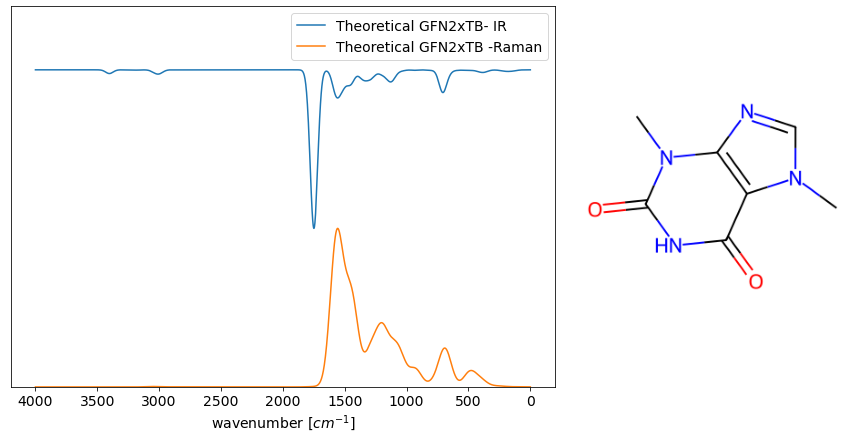

In [4]:
plt.rcParams.update({'font.size': 14})
smiles             = input("please introduce the smiles code: ")
method             = input("please introduce the method (GFN2xTB, GFN1xTB, GFNFF): ")
sigma              = int(input("please introduce how much you want to broad the theoretical bands (a number between σ=[20,100]): "))
sigma_raman        = int(input("please introduce how much you want to broad the Raman theoretical bands (a number between σ=[20,100]): "))

Ploter_IR_theoretical(smiles,method,sigma,sigma_raman)
plt.savefig("IR_Raman_TheoreticalSpectra_{0}_{1}.png".format(method, smiles))


# Cellphone environment

NOTE: The clauses after the symbol # are instructions. See the last cell to execute and get the spectra of your molecule 

Populate the following variables as follows:
```python 


smiles             = "CCCO" # STRING
method             =   "GFN2xTB"  # STRING #"please introduce the method (GFN2xTB, GFN1xTB, GFNFF)
sigma              = 20 # INTEGER  #"please introduce how much you want to broad the IR theoretical bands (a number between σ=[20,100])
sigma_raman        =  20 # INTEGER  #"please introduce how much you want to broad the Raman theoretical bands (a number between σ=[20,100])
```


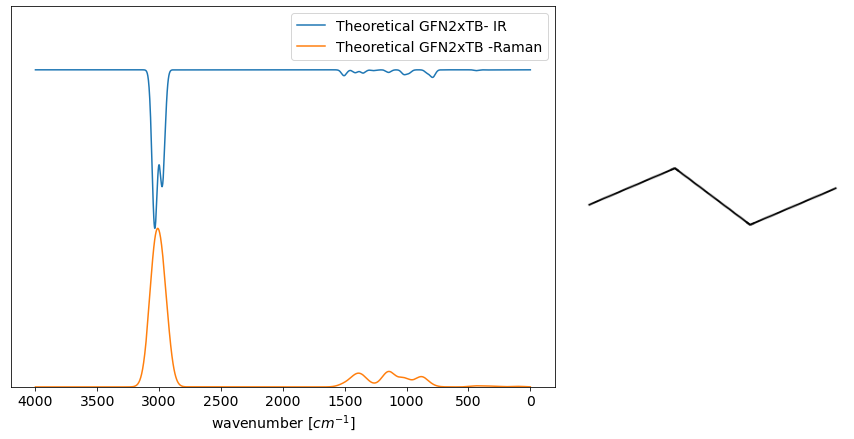

In [5]:
plt.rcParams.update({'font.size': 14})
smiles             = "CCCC"
method             = "GFN2xTB"
sigma              = 20
sigma_raman        = 50


Ploter_IR_theoretical(smiles,method,sigma,sigma_raman)
plt.savefig("IR_Raman_TheoreticalSpectra_{0}_{1}.png".format(method, smiles))